![Banner](./img/AI_Special_Program_Banner.jpg)


# Association analysis with Python
---

In this notebook, we want to look at an association analysis in Python. Unfortunately, `scikit-learn` does not offer a method for association analysis directly. However, there is the package [Mlxtend](https://github.com/rasbt/mlxtend) by [Sebastian Raschka](https://sebastianraschka.com/), which can be used to find association rules. A tutorial on this can be found on the website [Practical Business Python](http://pbpython.com/market-basket-analysis.html). The package can be installed with
```
conda install mlxtend
```

## Table of contents
---

- [Reading in the data](#Reading-in-the-data)
- [Preliminary considerations for data sparsity](#Preliminary-considerations-for-data-sparsity)
- [Determination of rules](#Determination-of-rules)
- [Learning outcomes](#Learning-outcomes)

## Reading in the data
---

The data used for this analysis ("*Groceries*") comes from the R library [*arules*](https://cran.r-project.org/web/packages/arules/index.html). This is a data set of **grocery purchases**.

We first import the required libraries again.

In [1]:
import csv
import pandas as pd
PREVIOUS_MAX_ROWS = pd.options.display.max_rows
pd.options.display.max_rows = 20
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from mlxtend.preprocessing import TransactionEncoder # früher: OnehotTransactions
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

We read in the CSV file in the form of a list, which we will then process further using the `Mlxtend` methods.

In [2]:
with open('data/groceries_r_quoted.csv', 'r') as f:
    reader = csv.reader(f)
    transactions = list(reader)
transactions[:5]

[['citrus fruit', 'semi-finished bread', 'margarine', 'ready soups'],
 ['tropical fruit', 'yogurt', 'coffee'],
 ['whole milk'],
 ['pip fruit', 'yogurt', 'cream cheese ', 'meat spreads'],
 ['other vegetables',
  'whole milk',
  'condensed milk',
  'long life bakery product']]

We first need a [One Hot Encoding](http://rasbt.github.io/mlxtend/api_subpackages/mlxtend.preprocessing/#transactionencoder) of the data read in. We do this again with the *fit-transform* procedure known from `scikit-learn` and save the result in a data frame.

In [3]:
oht = TransactionEncoder()
oht_ary = oht.fit(transactions).transform(transactions)
transactdf = pd.DataFrame(oht_ary, columns=oht.columns_)
transactdf.head()

,Instant food products,UHT-milk,abrasive cleaner,artif. sweetener,baby cosmetics,baby food,bags,baking powder,bathroom cleaner,beef,...,turkey,vinegar,waffles,whipped/sour cream,whisky,white bread,white wine,whole milk,yogurt,zwieback
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False


**Note:** Classic *OneHotEncoding* would use 0 and 1 instead of `False` and `True`, but this is just a question of data type and booleans require less memory.

Number of transactions and articles:

In [4]:
transactdf.shape

(9835, 169)

This is therefore a data set with 9835 transactions for 169 different articles.

Statistics on the size of transactions:

In [5]:
transactdf.sum(axis=1).describe()

count    9835.000000
mean        4.409456
std         3.589385
min         1.000000
25%         2.000000
50%         3.000000
75%         6.000000
max        32.000000
dtype: float64

In [6]:
from collections import Counter
Counter(transactdf.sum(axis=1)).most_common(5)

[(1, 2159), (2, 1643), (3, 1299), (4, 1005), (5, 855)]

This means that a single item was purchased most frequently. On average (we use the median as a measure for this), 3 items were purchased together. A maximum of 32 items were purchased together.

## Preliminary considerations for data sparsity
---

It is obvious that our data matrix contains predominantly 'false' values, as only a small subset of all available items is purchased per transaction. A matrix that predominantly contains zero values is called a sparse matrix. In the following, we want to specify a measure for sparseness:

In [7]:
ntransact = transactdf.shape[0]
ntransact

9835

In [8]:
nitems = transactdf.shape[1]
nitems

169

In [9]:
nnz = np.count_nonzero(transactdf)
nnz

43367

In [10]:
sparsity = 100 * nnz / (ntransact*nitems)
print("The feature matrix has ~{0:.2f}% non-null entries.".format(sparsity))

The featura matrix has ~2.61% not null entries.


In the association analysis, we are interested in relative frequencies. To be able to plot the frequencies, we first generate a list of the support values, which we can then filter and visualize appropriately.

In [11]:
supplist = transactdf.sum().sort_values(ascending=False)/ntransact
supplist.head()

whole milk          0.255516
other vegetables    0.193493
rolls/buns          0.183935
soda                0.174377
yogurt              0.139502
dtype: float64

Filtering of articles with a support of at least 10%:

In [12]:
supplist[supplist>=0.1]

whole milk          0.255516
other vegetables    0.193493
rolls/buns          0.183935
soda                0.174377
yogurt              0.139502
bottled water       0.110524
root vegetables     0.108998
tropical fruit      0.104931
dtype: float64

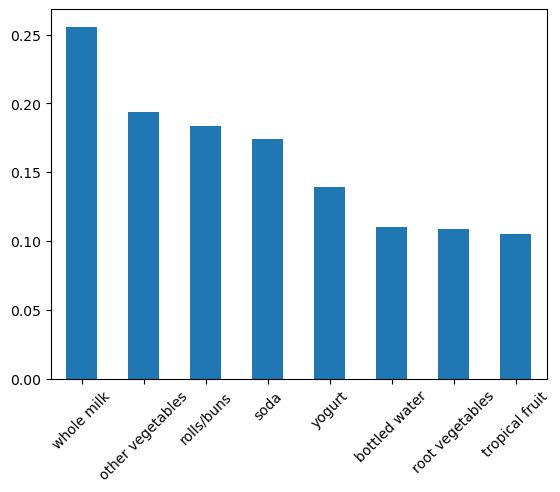

In [13]:
supplist[supplist>=0.1].plot(kind='bar', rot=45)
plt.show()

Or the 20 most frequent articles:

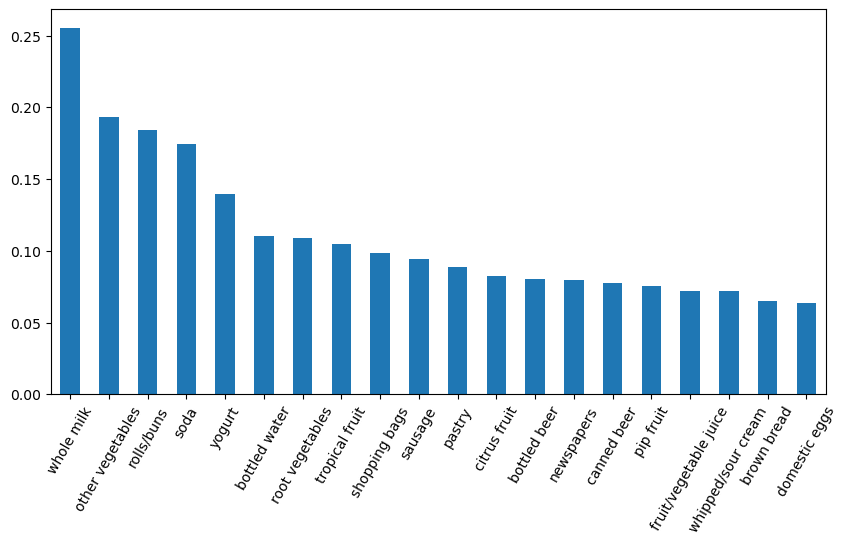

In [14]:
supplist.head(20).plot(kind='bar', rot=60, figsize=(10,5))
plt.show()

## Determination of the rules
---

To determine the *large itemsets*, we use the [a-priori algorithm from `Mlxtend`](http://rasbt.github.io/mlxtend/user_guide/frequent_patterns/apriori/) and require a minimum support of 6 per thousand. The default value of 50% is not met by any item in our data.

In [15]:
frequent_itemsets = apriori(transactdf, min_support=0.006, use_colnames=True)

In [16]:
type(frequent_itemsets)

pandas.core.frame.DataFrame

Here we explicitly receive the large itemsets in a Pandas Data Frame, from which we view a section.

In [17]:
frequent_itemsets[400:410]

,support,itemsets
400,0.007016,"(soda, hygiene articles)"
401,0.006711,"(tropical fruit, hygiene articles)"
402,0.012811,"(whole milk, hygiene articles)"
403,0.007321,"(yogurt, hygiene articles)"
404,0.006101,"(soda, ice cream)"
405,0.010676,"(long life bakery product, other vegetables)"
406,0.007931,"(long life bakery product, rolls/buns)"
407,0.007626,"(soda, long life bakery product)"
408,0.006304,"(long life bakery product, tropical fruit)"
409,0.013523,"(long life bakery product, whole milk)"


The *rules* are now generated in a second step, whereby metrics other than confidence can be used flexibly here (see the [documentation](http://rasbt.github.io/mlxtend/user_guide/frequent_patterns/association_rules/)). We select a quarter as the confidence.

In [18]:
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.25)
rules.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(baking powder),(other vegetables),0.017692,0.193493,0.007321,0.413793,2.138547,0.003898,1.375807,0.541982
1,(baking powder),(whole milk),0.017692,0.255516,0.009253,0.522989,2.046793,0.004732,1.560725,0.520642
2,(beef),(other vegetables),0.052466,0.193493,0.019725,0.375969,1.943066,0.009574,1.292416,0.512224
3,(beef),(rolls/buns),0.052466,0.183935,0.013625,0.259690,1.411858,0.003975,1.102329,0.307866
4,(beef),(root vegetables),0.052466,0.108998,0.017387,0.331395,3.040367,0.011668,1.332628,0.708251


In [19]:
rules.shape

(467, 10)

So we get 467 rules. More information is provided by `.info()`, for example:

In [20]:
rules.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 467 entries, 0 to 466
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   antecedents         467 non-null    object 
 1   consequents         467 non-null    object 
 2   antecedent support  467 non-null    float64
 3   consequent support  467 non-null    float64
 4   support             467 non-null    float64
 5   confidence          467 non-null    float64
 6   lift                467 non-null    float64
 7   leverage            467 non-null    float64
 8   conviction          467 non-null    float64
 9   zhangs_metric       467 non-null    float64
dtypes: float64(8), object(2)
memory usage: 36.6+ KB


It is noticeable that two new metrics, namely *leverage* and *conviction*, are also specified (more on this in the exercises). Another common terminology for the rules is also used here, in that the precondition is referred to as *antecedent* and the conclusion as *consequent*.

What is missing, however, is the *absolute frequency*, i.e. the *count*. However, since we are dealing with a DataFrame, we can simply add a new column to it that contains the count. We calculate it from the *support* (i.e. the *relative frequency*) by multiplying it by the number of all transactions, adding 0.2 to avoid rounding errors, before converting the result into an integer.

In [21]:
rules["count"] = rules.support.apply(lambda x: int(x*ntransact+0.2))
rules.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric,count
0,(baking powder),(other vegetables),0.017692,0.193493,0.007321,0.413793,2.138547,0.003898,1.375807,0.541982,72
1,(baking powder),(whole milk),0.017692,0.255516,0.009253,0.522989,2.046793,0.004732,1.560725,0.520642,91
2,(beef),(other vegetables),0.052466,0.193493,0.019725,0.375969,1.943066,0.009574,1.292416,0.512224,194
3,(beef),(rolls/buns),0.052466,0.183935,0.013625,0.259690,1.411858,0.003975,1.102329,0.307866,134
4,(beef),(root vegetables),0.052466,0.108998,0.017387,0.331395,3.040367,0.011668,1.332628,0.708251,171


As you can see, not all the rules are obvious and perhaps you would have to adjust the parameters a little to not believe that baking soda is a good indicator for vegetables ... (but perhaps there is a secret truth behind this ...).

You might get more interesting results if you look at the rules with the highest *lift*.

In [22]:
rules.sort_values("lift", ascending=False)[0:7]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric,count
456,"(root vegetables, tropical fruit)","(whole milk, other vegetables)",0.021047,0.074835,0.007016,0.333333,4.454257,0.005441,1.387748,0.792169,69
461,"(yogurt, root vegetables)","(whole milk, other vegetables)",0.025826,0.074835,0.007829,0.303150,4.050919,0.005896,1.327638,0.773109,77
81,(herbs),(root vegetables),0.016268,0.108998,0.007016,0.431250,3.956477,0.005243,1.566596,0.759608,69
7,(berries),(whipped/sour cream),0.033249,0.071683,0.009049,0.272171,3.796886,0.006666,1.275461,0.761960,89
455,"(tropical fruit, whole milk, other vegetables)",(root vegetables),0.017082,0.108998,0.007016,0.410714,3.768074,0.005154,1.512003,0.747379,69
151,"(other vegetables, beef)",(root vegetables),0.019725,0.108998,0.007931,0.402062,3.688692,0.005781,1.490123,0.743568,78
304,"(tropical fruit, other vegetables)",(pip fruit),0.035892,0.075648,0.009456,0.263456,3.482649,0.006741,1.254985,0.739401,93


Inspired by the rule with ID 7, let's take a look at other rules that have to do with "berries".

Here you first need to know that the *antecedents* are so-called [frozensets](https://www.python-course.eu/sets_frozensets.php), so you need to check whether they are a superset of the set `{'berries'}`.

In [23]:
type(rules.antecedents.values[0])

frozenset

In [24]:
#rules['berries' in rules.antecedants.values] <- das geht so leider nicht!
rules[rules.antecedents.apply(lambda x: x.issuperset({'berries'}))]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric,count
6,(berries),(other vegetables),0.033249,0.193493,0.010269,0.308869,1.596280,0.003836,1.166938,0.386391,101
7,(berries),(whipped/sour cream),0.033249,0.071683,0.009049,0.272171,3.796886,0.006666,1.275461,0.761960,89
8,(berries),(whole milk),0.033249,0.255516,0.011795,0.354740,1.388328,0.003299,1.153774,0.289329,116
9,(berries),(yogurt),0.033249,0.139502,0.010574,0.318043,2.279848,0.005936,1.261807,0.580681,104


Or we are only interested in those rules where there is a *substitution effect*.

In [25]:
rules[rules.lift<1.0]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric,count
11,(bottled beer),(whole milk),0.080529,0.255516,0.020437,0.253788,0.993237,-0.000139,0.997684,-0.007351,201


In [26]:
pd.options.display.max_rows = PREVIOUS_MAX_ROWS

## Learning outcomes
---

If you carefully studied the materials provided within these documents, you should have a fundamental grasp of association analysis in machine learning, including the following points:

* originates in market basket analysis to promote cross-selling,
* unsupervised learning method based on rules of the form "If $X$, then $Y$"
($X \rightarrow Y$)
* rules are based on descriptive statistics, especially relative frequencies of item sets,
* the rules can depend on the parameters used and interpretation depends largely on the use-case.